In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import sys
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import sys
from platypus import NSGAII, Problem, Real, nondominated, Integer
import matplotlib.pyplot as plt
from platypus.problems import DTLZ2
import scipy

sys.path.append(os.path.abspath("../class_dir"))
from circuit_class import Circuit
from standingwave_class import Standingwave
# from standingwave_class import Standingwave
from circuit_class import get_test_name

# 並列共振回路ver.

シミュレーションを回しなおさなくていい場合、**<span style="color: green; "> 緑太字で示した部分</span>**をコメントアウトする

## コイルのインダクタンスLと直列負荷抵抗Rを変数としたシミュレーション

### <span style="color: red; ">変数指定</span>
テストするL, Rの範囲と間隔を指定(単位はLはμH, RはΩ)

In [42]:
# Lは単位μH, 範囲指定はlogスケールで行う
L_start = -1
L_end = 3
L_num = 60

# Rは単位Ω, 範囲指定は線形スケールで行う
R_start = -1
R_end = 3
R_num = 40

# 結合係数Kは0.1で固定
K=0.1

# t_cutは5msシミュレーションなので0.0049
t_cut_time = 0.0049

# テスト元にするcirファイルのパス
cir_path = '/Users/yuki/Documents/LTspice/test/parallel_0912/main_parallel'

変数のリストを用意

In [43]:
# 浮動少数点数型の変数の配列
L_values_num = list(np.logspace(L_start, L_end, L_num))
R_values_num = list(np.logspace(R_start, R_end, R_num))

# 文字列型の変数の配列
L_values = list(map(lambda x: str(x)+"u", L_values_num))
R_values = list(map(lambda x: str(x), R_values_num))

収集するデータのDataFrame用のカラムを準備

In [44]:
columns = ['L','L_str', 'R', 'R_str', 'V(out)', 'W']

## <span style="color: red; ">条件増やしたり変えたらここも変更チェック
条件を表す文字列を作成

In [45]:
condition = 'parallel_0912'
condition += f'_L:{L_values[0]}~{L_values[-1]}(n={L_num})_R:{R_values[0]}~{R_values[-1]}(n={R_num})_K:{K}'
condition
R_values

['0.1',
 '0.12663801734674032',
 '0.160371874375133',
 '0.20309176209047358',
 '0.2571913809059345',
 '0.3257020655659783',
 '0.41246263829013524',
 '0.5223345074266842',
 '0.6614740641230149',
 '0.8376776400682918',
 '1.0608183551394483',
 '1.3433993325989002',
 '1.7012542798525891',
 '2.1544346900318834',
 '2.728333376486768',
 '3.455107294592218',
 '4.3754793750741845',
 '5.541020330009492',
 '7.017038286703826',
 '8.886238162743403',
 '11.253355826007645',
 '14.251026703029977',
 '18.047217668271703',
 '22.854638641349908',
 '28.942661247167518',
 '36.65241237079626',
 '46.41588833612777',
 '58.780160722749116',
 '74.43803013251689',
 '94.26684551178855',
 '119.37766417144357',
 '151.17750706156616',
 '191.44819761699577',
 '242.44620170823282',
 '307.029062975785',
 '388.81551803080856',
 '492.38826317067367',
 '623.5507341273913',
 '789.6522868499725',
 '1000.0']

結果保存用の条件別のフォルダを作成

In [6]:
result_dir = f'result/{condition}'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

## 全パターンのシミュレーションの実行

### <span style="color: green; ">完了している場合はコメントアウトしておく

In [7]:
# change_elements = {}
# change_elements['K'] = K

# for L in tqdm(L_values):
#     parallel = Circuit(cir_path)
#     change_elements['L'] = L
#     for R in tqdm(R_values):
#         change_elements['R'] = R
#         parallel.change_element_run(change_elements)
#     del parallel
#     gc.collect()

## シミュレーション結果をcsvに保存

### <span style="color: green; ">完了している場合はコメントアウトしておく

In [8]:
# sim_df = pd.DataFrame(columns= columns)
# change_elements = {}
# change_elements['K'] = K

# for l in tqdm(range(len(L_values))):
#     change_elements['L'] = L_values[l]
#     for r in range(len(R_values)):
#         change_elements['R'] = R_values[r]
#         test_name = get_test_name(change_elements)
#         parallel = Standingwave(cir_path)
#         parallel.change_element_df_save(change_elements)
#         parallel.t_cut(0.0049)
#         v = parallel.get_amp_means()["V(test)"][test_name]
#         W_mean = parallel.get_W('I(R1)', 'V(a)', change_elements=change_elements, t_cut_time=t_cut_time)['W'].mean()
#         sim_df = sim_df.append({'L': L_values_num[l], 'L_str': L_values[l], 'R': R_values_num[r], 'R_str': R_values[r], 'V(out)': v, 'W': W_mean}, ignore_index=True)
#         del parallel
#         gc.collect()
# sim_df.to_csv(f'{result_dir}/LR_VW.csv')

## csvからデータを読みこみ

In [9]:
csv_df = pd.read_csv(f'{result_dir}/LR_VW.csv', dtype = {'L_str':'object', 'R_str':'object'})

# 出力側電圧

## L別にRと出力側電圧振幅の関係をみる

波形確認

In [10]:
# change_elements = {}
# change_elements['K'] = K

# # count = 0

# for L in tqdm(L_values[50:60]):
#     parallel = Standingwave(cir_path)
#     change_elements['L'] = L
#     for R in R_values:
#         change_elements['R'] = R
#         parallel.change_element_df_save(change_elements)
#     parallel.t_cut(0.0049)
# #     if count>55:
#     parallel.dfs["V(test)"][f'K=0.1L={L}R=1000.0'].plot(x="t", y="V(test)", title = f'L={L}H')
#     del parallel
#     gc.collect()

描画(x, yどちらも対数軸)して保存

In [11]:
ncols=3
nrows = 1+len(L_values)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
plt_count = 0
for L in L_values:
    csv_df[csv_df['L_str']==L].plot(x="R", y="V(out)", title = f'L={L}uH', loglog = True, ax=axes[plt_count//ncols, plt_count%ncols])
    plt_count+=1
plt.savefig(f'{result_dir}/R_amp.png')
plt.close('all')

## R別にLと出力側電圧振幅の関係をみる

描画(x, yどちらも対数軸)して保存

In [12]:
ncols=3
nrows = 1+len(R_values)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
plt_count = 0
for R in R_values:
    csv_df[csv_df['R_str']==R].plot(x="L", y="V(out)", title = f'R={R}Ω', loglog = True, ax=axes[plt_count//ncols, plt_count%ncols])
    plt_count+=1
plt.savefig(f'{result_dir}/L_amp.png')
plt.close('all')

## 出力電圧が最高だったテストパターン

In [13]:
max_v = csv_df[csv_df['V(out)']==csv_df['V(out)'].max()]
max_v

,Unnamed: 0,L,L_str,R,R_str,V(out),W
2220,2220,32.245905,32.245905452963946u,1.0,1.0,0.635236,0.007987


# 入力側消費電力

## L別でRと整定後の平均消費電力の関係をみる

波形確認

In [14]:
# change_elements = {}
# change_elements['K'] = K

# ncols=3
# nrows = 1+20//ncols

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
# plt_count = 0

# for L in tqdm(L_values[59:60]):
#     parallel = Standingwave(cir_path)
#     change_elements['L'] = L
#     hoge = 0
#     for R in R_values:
#         change_elements['R'] = R
#         if hoge < 20:
#             w = parallel.get_W('I(R1)', 'V(a)', change_elements=change_elements)
#             w.plot(x="t", y="W", title = f'R={R}Ω', ax=axes[plt_count//ncols, plt_count%ncols])
#             plt_count+=1
#         hoge +=1
#     del parallel
#     gc.collect()
# plt.savefig(f'{result_dir}/W_waves_L=1000.png')
# plt.close('all')

描画(x, yどちらも対数軸)して保存

In [15]:
ncols=3
nrows = 1+len(L_values)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
plt_count = 0
for L in L_values:
    csv_df[csv_df['L_str']==L].plot(x="R", y="W", title = f'L={L}uH', loglog = True, ax=axes[plt_count//ncols, plt_count%ncols])
    plt_count+=1
plt.savefig(f'{result_dir}/R_W.png')
plt.close('all')

## R別でLと整定後の平均消費電力の関係をみる

描画(x, yどちらも対数軸)して保存

In [16]:
ncols=3
nrows = 1+len(R_values)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6*nrows))
plt_count = 0
for R in R_values:
    csv_df[csv_df['R_str']==R].plot(x="L", y="W", title = f'R={R}Ω', loglog = True, ax=axes[plt_count//ncols, plt_count%ncols])
    plt_count+=1
plt.savefig(f'{result_dir}/L_W.png')
plt.close('all')

## 平均消費電力が最小だったテストパターン

In [17]:
min_w = csv_df[csv_df['V(out)']==csv_df['V(out)'].max()]
min_w

,Unnamed: 0,L,L_str,R,R_str,V(out),W
2220,2220,32.245905,32.245905452963946u,1.0,1.0,0.635236,0.007987


# 出力電圧と平均消費電力を２軸プロットする

In [29]:
csv_df.plot(x="V(out)", y="W", kind='scatter')
plt.xlabel("$V_{Lout}[V]$", size=10)
plt.ylabel("$W_{in}$[W]",size=10)
plt.savefig(f'{result_dir}/vout_w_scatterd.png')
plt.close('all')

### NSGA-Ⅱを用いたパレート最適解の抽出
多目的最適化問題に用いられる多目的遺伝的アルゴリズムのNSGA-Ⅱ(詳細はhttps://qiita.com/DS27/items/025a52b26a9f2471e67c )を用いて、非劣解を抽出する.
用いているplatypusライブラリに関しては https://qiita.com/pontyo4/items/d8812e4f46850d746fcd を軽く参照

In [19]:
def obj_func(args):
    L_num = args[0]
    R_num = args[1]
    data = csv_df[(csv_df['L_str']==L_values[L_num]) & (csv_df['R_str']==R_values[R_num])]
    return [float(data['V(out)']),float(data.W)]

problem = Problem(2, 2)
problem.directions[:] = [Problem.MAXIMIZE, Problem.MINIMIZE]
L_num = Integer(0, len(L_values)-1)
R_num = Integer(0, len(R_values)-1)
problem.types[:] = [L_num, R_num]
problem.function = obj_func

algorithm = NSGAII(problem, population_size = 50)
algorithm.run(10000)

# 非劣解をとりだす
nondominated_solutions = nondominated(algorithm.result)

# グラフを描画
plt.scatter([s.objectives[0] for s in nondominated_solutions if s.feasible],
           [s.objectives[1] for s in nondominated_solutions if s.feasible])
plt.savefig(f'{result_dir}/vout_w_pareto.png')
plt.close('all')

In [20]:
df = pd.DataFrame(columns=("L", "L_str", "R", "R_str", "V(out)", "W"))
for i in range(len(nondominated_solutions)):
    df.loc[i, "L"] = L_values_num[L_num.decode(nondominated_solutions[i].variables[0])]
    df.loc[i, "R"] = R_values_num[R_num.decode(nondominated_solutions[i].variables[1])]
    df.loc[i, "L_str"] = L_values[L_num.decode(nondominated_solutions[i].variables[0])]
    df.loc[i, "R_str"] = R_values[R_num.decode(nondominated_solutions[i].variables[1])]
    df.loc[i, "V(out)"] = nondominated_solutions[i].objectives[0]
    df.loc[i, "W"] = nondominated_solutions[i].objectives[1]
df.sort_values(['L', 'R'], ascending = [False, False])
df.to_csv(result_dir+'/pareto_set.csv')

In [32]:
df[(df["V(out)"]>0.58)&(df["V(out)"]<0.61)].sort_values('V(out)')

,L,L_str,R,R_str,V(out),W
35,1000.0,1000.0u,108.118075,108.11807510766077,0.582867,0.000516
46,1000.0,1000.0u,60.208945,60.208944933361316,0.588309,0.000592
49,1000.0,1000.0u,47.63938,47.63938010401343,0.591174,0.000626
45,855.467254,855.4672535565685u,29.824713,29.824712862168912,0.593101,0.000727
47,626.051657,626.0516572014822u,47.63938,47.63938010401343,0.596798,0.00075
38,626.051657,626.0516572014822u,29.824713,29.824712862168912,0.599037,0.000838
29,458.159767,458.1597669054491u,29.824713,29.824712862168912,0.603494,0.00094
28,391.940677,391.94067748472213u,20.991037,20.991037201085547,0.605244,0.001159
32,245.375111,245.37511066398167u,23.598335,23.59833466782195,0.605419,0.001344
33,286.831681,286.83168133420116u,18.671811,18.671810912919206,0.608329,0.001503


<AxesSubplot:xlabel='V(out)', ylabel='W'>

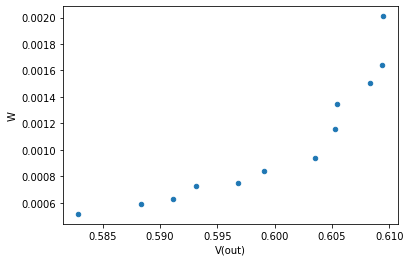

In [31]:
df[(df["V(out)"]>0.58)&(df["V(out)"]<0.61)].plot(x='V(out)', y='W', kind='scatter')

In [34]:
L= 500*10**(-6)
f = 200*10**3
c=1/(L*((2*np.pi*f)**2))
c

1.2665147955292225e-09